# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [68]:
# Load pickled data
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn import preprocessing
import cv2
import random
# Visualizations will be shown in the notebook.
%matplotlib inline
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

Practice stuff:

In [69]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.

n_classes = len(np.unique(y_train))
test_classes = len(np.unique(y_test))
print('Train classes: {} Test classes: {}'.format(n_classes, n_test))
print('Training examples: {}, Testing examples: {}'.format(n_train, n_test))
print("Number of training examples =", n_train)
print('Number of training labels: (not unique): ',y_train.shape)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Train classes: 43 Test classes: 12630
Training examples: 39209, Testing examples: 12630
Number of training examples = 39209
Number of training labels: (not unique):  (39209,)
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Create validation set: 
#### X_train: 80% , X_validation: 20% (examples)
#### y_train: 80% , y_validation: 20% (labels)

In [70]:
# Create validation set:, likely using sklearn
import math
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = .80, test_size = 0.20)
print('X_train shape:', X_train.shape)
print('X_validate shape:', X_validation.shape)
print('y_train shape: ', y_train.shape)
print('y_validate shape: ', y_validation.shape)
training_percentage = X_train.shape[0] / n_train
num_training_examples = X_train.shape[0]
num_validation_examples = X_validation.shape[0]
print('num_training_examples: ', num_training_examples)
print('num_validation_examples: ', num_validation_examples)
print('training percentage: ', training_percentage)
assert(0.79 < training_percentage < 0.801)
print('training_percentage confirmed!')


X_train shape: (31367, 32, 32, 3)
X_validate shape: (7842, 32, 32, 3)
y_train shape:  (31367,)
y_validate shape:  (7842,)
num_training_examples:  31367
num_validation_examples:  7842
training percentage:  0.7999948991303018
training_percentage confirmed!


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

# Read classes label data csv (signnames.csv)
### contains: index | classId | SignName
##### Example: 0    |   0    |    Speed limit (20km/h)

In [71]:
data_pd = pd.read_csv('signnames.csv')
data_i = [[class_number, sum(y_train == class_number)] for class_number in range(len(np.unique(y_train)))]
# Now we have a list with the indices of each class change in the y_train dataset
# data_i is an array of tuples (class_number, # of occurances)

# Now we wish to sort this list from most common occurances to least common occurances
data_i_sorted = sorted(data_i, key = lambda i: i[1])
data_i_sorted_array = np.array(data_i_sorted)

# Use occurance as [1] and index set to the indexes as .T[0]
data_pd['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index = np.asarray(data_i_sorted).T[0])

data_pd_sorted = data_pd.sort_values(['Occurance'], ascending = [0]).reset_index()
# Now drop the 2nd axis titled ('index' because its annoying (stay DRY))
data_pd_sorted = data_pd_sorted.drop('index', 1)

assert(len(data_pd) == len(np.unique(y_train)))

In [72]:
data_pd_sorted.head(9)

,ClassId,SignName,Occurance
0,2,Speed limit (50km/h),1801
1,1,Speed limit (30km/h),1793
2,13,Yield,1699
3,38,Keep right,1657
4,12,Priority road,1638
5,10,No passing for vehicles over 3.5 metric tons,1632
6,4,Speed limit (70km/h),1590
7,5,Speed limit (80km/h),1503
8,25,Road work,1218


In [73]:
data_pd_sorted.tail(10)

,ClassId,SignName,Occurance
33,39,Keep left,245
34,24,Road narrows on the right,213
35,29,Bicycles crossing,209
36,42,End of no passing by vehicles over 3.5 metric ...,194
37,32,End of all speed and passing limits,194
38,27,Pedestrians,193
39,41,End of no passing,185
40,37,Go straight or left,171
41,19,Dangerous curve to the left,170
42,0,Speed limit (20km/h),160


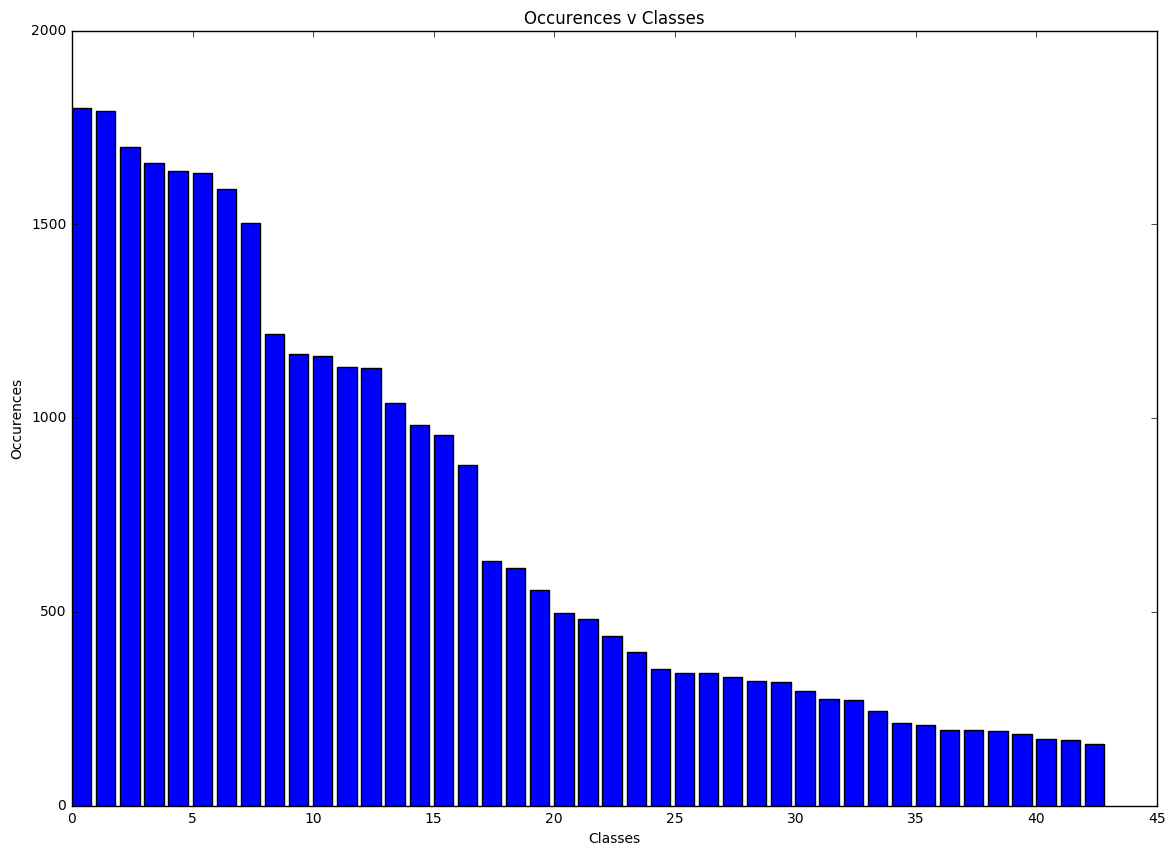

In [74]:
plt.figure(figsize = (14, 10))
plt.bar(range(43), height = data_pd_sorted['Occurance'])
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.title('Occurences v Classes')

In [75]:
print(y_train[400])
print()

13



In [76]:
def plot_class_occurence_random_sample(n_row, n_col, X, y):
    plt.figure(figsize = (8, 8))
    gs1 = gridspec.GridSpec(4, 4) #GridSpec(row, col)
    gs1.update(wspace = 0.01, hspace = 0.02) #spacing bw axes
    
    for i in range(n_row * n_col):
        ax1 = plt.subplot(gs1[i])
        rand_index = np.random.randint(0, len(y)) # pick a random index in labels

        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        occurence = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_train[rand_index]]['Occurance'].values[0]
        sign_name = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_train[rand_index]]['SignName'].values[0]
        plt.text(0, 0, "class: " + str(y_train[rand_index]) + "\noccurence: " + str(occurence) + "\nname: " + str(sign_name), 
                color = 'k', backgroundcolor = 'g')
        plt.imshow(X_train[rand_index])
        plt.axis('off')
    plt.show()

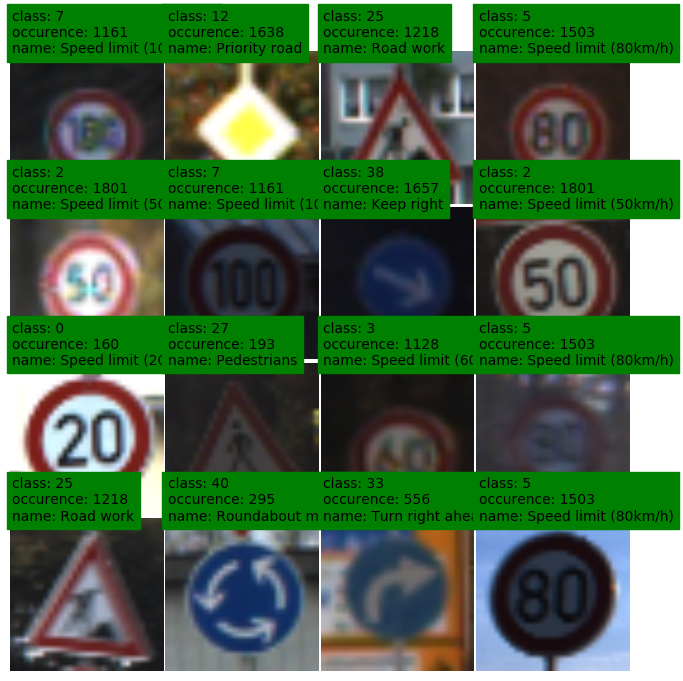

In [77]:
plot_class_occurence_random_sample(4, 4, X_train, y_train)

## Comments:

As you can see, there is a big difference in the abudance of each traffic sign's class. Some signs are heavily abundant, and some are sparse. We seek to level this out by taking the sparse classes, rotating their images, and creating more of them.

# Histogram Equalization

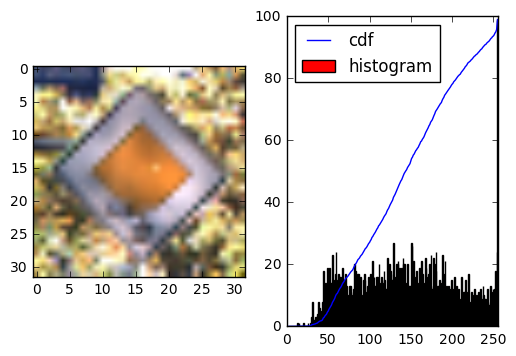

In [129]:

# # Normal Histogram Equalization
# rand_int = np.random.randint(0, len(y_train))

# img = X_train[rand_int]

# hist,bins = np.histogram(img.flatten(),256,[0,256])

# cdf = hist.cumsum()
# cdf_normalized = cdf * hist.max()/ cdf.max()


# plt.subplot(121)
# plt.imshow(img)

# plt.subplot(122)
# plt.plot(cdf_normalized, color = 'b')
# plt.hist(img.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')

# plt.show()



rand_int:  24199
equalize_y3 shape:  (32, 32)


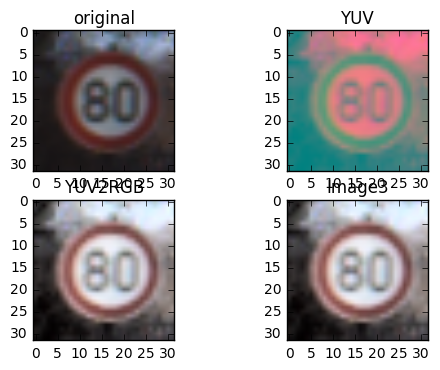

In [203]:
# Constrast Limited Histogram Equalization
rand_int = np.random.randint(0, len(y_train))
print('rand_int: ', rand_int)
# Change image from RGB to YUV
image1 = np.copy(X_train[rand_int])
image2 = X_train[rand_int]


# Convert to YUV
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2YUV)
Yimage2 = image2[:,:,0]
equalize_y2 = cv2.equalizeHist(Yimage2)
image2[:,:,0] = equalize_y2
# Back to RGB
image2RGB = cv2.cvtColor(image2, cv2.COLOR_YUV2RGB)


image3 = X_train[rand_int]
Yimage3 = image3[:,:,0]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
equalize_y3 = clahe.apply(Yimage3)
print('equalize_y3 shape: ', equalize_y3.shape)
image3[:,:,0] = equalize_y3
image3RGB = cv2.cvtColor(image2, cv2.COLOR_YUV2RGB)

plt.subplot(221)
plt.title('original')
plt.imshow(image1)

plt.subplot(222)
plt.title('YUV')
plt.imshow(image2)

plt.subplot(223)
plt.title('YUV2RGB')
plt.imshow(image2RGB)

plt.subplot(224)
plt.title('Image3')
plt.imshow(image3RGB)

plt.show()




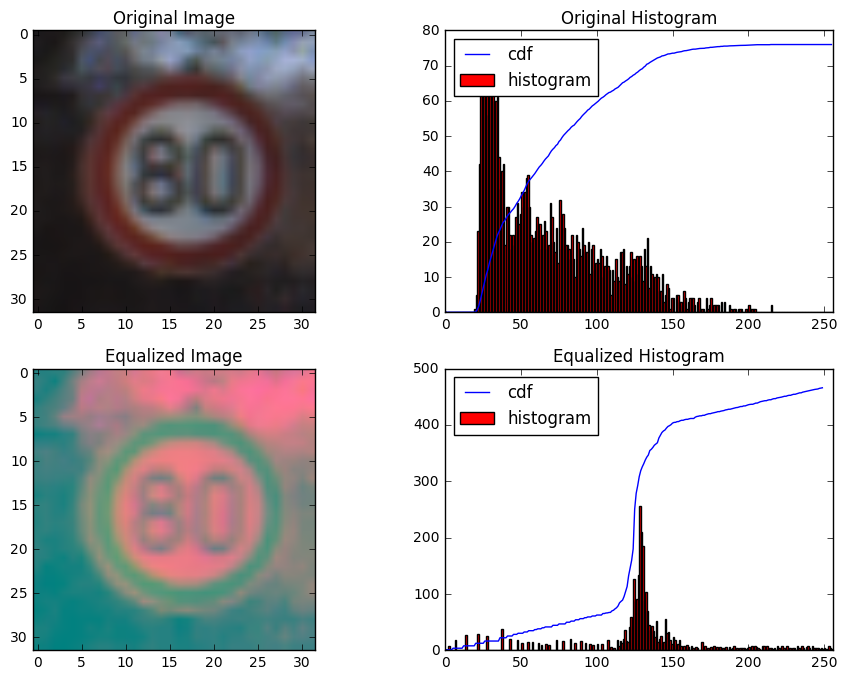

In [204]:
plot_histograms(image1, image2)

### Compare Normal Histogram Equalization v CLAHE Equalization

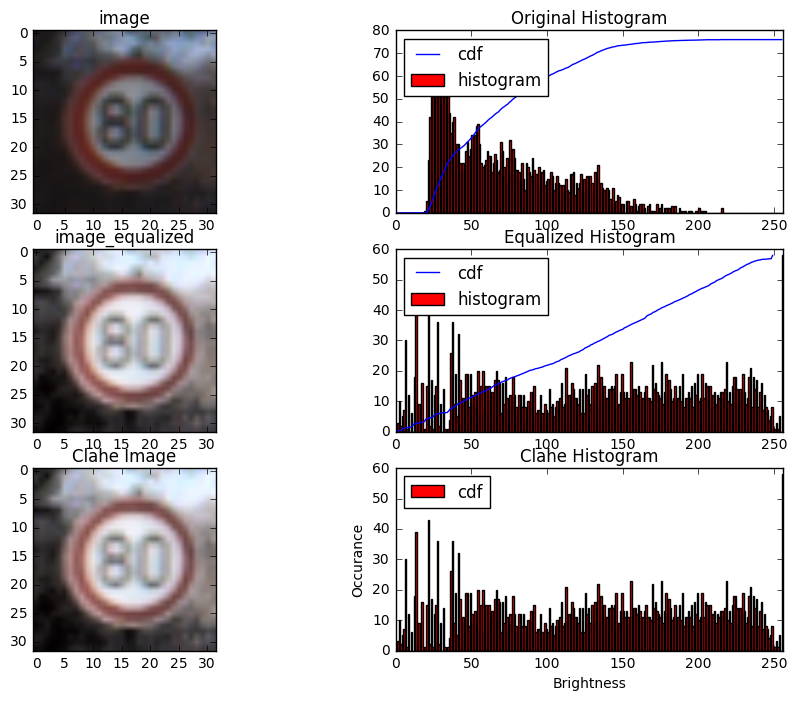

In [215]:
plot_histograms(image1, image2RGB, image3RGB)

In [214]:
def plot_histograms(image, image_equalized, image_clahe):
    plt.figure(figsize = (11,8))
    
    # Image
    hist_image,bins_image = np.histogram(image.flatten(),256,[0,256])
    cdf_image = hist_image.cumsum()
    cdf_normalized_image = cdf_image * hist_image.max()/ cdf_image.max()
    
    # Normal Equalization
    hist_image_equalized, bins_image_equalized = np.histogram(image_equalized.flatten(), 250, [0, 256])
    cdf_image_equalized = hist_image_equalized.cumsum()
    cdf_normalized_image_equalized = cdf_image_equalized * hist_image_equalized.max() / cdf_image_equalized.max()
    
    # CLAHE equalization
    hist_image_clahe, bins_image_clahe = np.histogram(image_clahe.flatten(), 250, [0, 256])
    cdf_image_clahe = hist_image_clahe.cumsum()
    cdf_normalized_image_clahe = cdf_image_clahe * hist_image_clahe.max() / cdf_image_clahe.max()
    
    # Original image plot
    plt.subplot(321)
    plt.title('image')
    plt.imshow(image)

    # Original image histogram
    plt.subplot(322)
    plt.plot(cdf_normalized_image, color = 'b')
    plt.title('Original Histogram')
    plt.hist(image.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    
    # Equalized image plot
    plt.subplot(323)
    plt.title('image_equalized')
    plt.imshow(image_equalized)

    # Equalized image histogram
    plt.subplot(324)
    plt.plot(cdf_normalized_image_equalized, color = 'b')
    plt.title('Equalized Histogram')
    plt.hist(image_equalized.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    
    # CLAHE image plot
    plt.subplot(325)
    plt.title('Clahe Image')
    plt.imshow(image_clahe)
    
    # Clahe Histogram
    plt.subplot(326)
    plt.title('Clahe Histogram')
    plt.xlabel('Brightness')
    plt.ylabel('Occurance')
    plt.hist(image_clahe.flatten(), 256, [0, 256], color = 'r')
    plt.xlim([0, 256])
    plt.legend(('cdf', 'histogram'), loc = 'upper left')
    
    
    
plt.show()

In [44]:
def pre_process_image_histogram_equalization(image):
    if (image.shape[2] == 3):
        

In [45]:
pre_process_image_histogram_equalization(X_train[9])

image has color: 


# Brightness Augmentation

#### We perform histogram equalization so we can make the brightness values more consistent within each image

## Create more images by rotating and adding:

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# Preprocessing

In [26]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# First turn all the images into grayscale


X_train, y_train = shuffle(X_train, y_train)



rand_int = np.random.randint(0, len(y_train))
rand_image_original = np.copy(X_train[rand_int])
rand_image_name = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_train[rand_int]]['SignName'].values[0]
rand_image_gray = cv2.cvtColor(X_train[rand_int],cv2.COLOR_RGB2GRAY)

## Convert to grayscale and normalize


## Manual Normalization Grayscale Function

In [27]:
def normalize_grayscale(image_data):
    a = np.float32(0.05)
    b = np.float32(0.95)
    image_data_shape = image_data.shape
    gray_data = np.zeros(image_data.shape[:-1])
    for idx, image in enumerate(image_data):
        gray_data[idx] = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    x_max = np.max(gray_data, axis = 0)
    x_min = np.min(gray_data, axis = 0)
    gray_data_maxmin = a + (gray_data - x_min)*(b-a)/(x_max - x_min)
    return gray_data_maxmin

# Now compare this against using the sklearn library's distribution


## Manual Grayscale + normalization technique implemented

gray_data_maxmin shape:  (31367, 32, 32)
gray_data_maxmin values:  0.949999976903


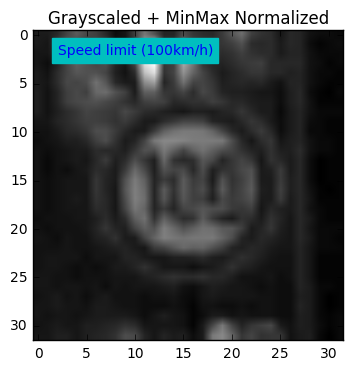

In [28]:
# Manual grayscale + normalization
gray_data_maxmin = normalize_grayscale(X_train)
print('gray_data_maxmin shape: ', gray_data_maxmin.shape)
print('gray_data_maxmin values: ', np.max(gray_data_maxmin))
random_gray_maxmin = gray_data_maxmin[rand_int]
plt.title('Grayscaled + MinMax Normalized')
rand_int_gray_name = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_train[rand_int]]['SignName'].values[0]
plt.text(2, 2, rand_int_gray_name, color = 'b', backgroundcolor = 'c')
plt.imshow(random_gray_maxmin, cmap="gray")

In [31]:
def plot_rand_original_grayscale_normalized(n_row, n_col,name,  original, grayscaled, maxmin_normalized):
    plt.figure(figsize = (11,8))
    
    plt.suptitle(name, fontsize = "12")
    plt.subplot(131)
    plt.axis('off')
    plt.title('Original')
    plt.imshow(original)
    
    plt.subplot(132)
    plt.axis('off')
    plt.title('Grayscaled')
    plt.imshow(grayscaled, cmap="gray")
    
    plt.subplot(133)
    plt.axis('off')
    plt.title('Grayscaled + Normalized')
    plt.imshow(maxmin_normalized, cmap="gray")
plt.show()

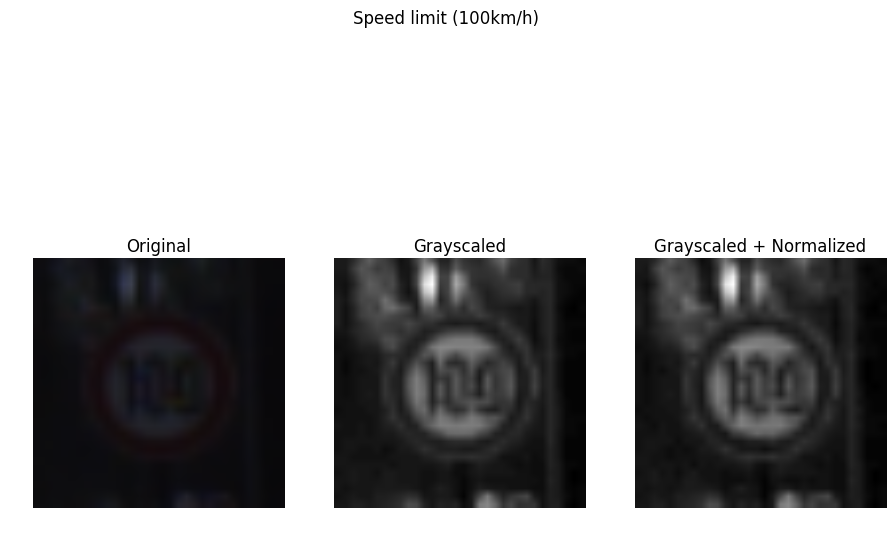

In [30]:
plot_rand_original_grayscale_normalized(4, 4, rand_image_name, rand_image_original, rand_image_gray, random_gray_maxmin)

### comment:
You can see we get better constrast after grayscaling and normalizing

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

### Answer:
My first conclusion was that I needed to perform histogram equalization before I grayscale + normalize because grayscale + normalization results in data loss. Even though it is slower to perform equalization over three layers, I didn't want to lose information about the data set.

#### Histogram Equalization + Brightness augmentation order:
I added brightness augmentation after histogram equalization. After we equalize the pixel distribution it appears "more normal". Then we add the randomness factor of brightness augmentation by increasing random brightness values to random parts of the image. This introduces a randomness factor which will prevent our model from overfitting because the model is being trained on images with random brightness values. If we performed brightness augmentation first followed by histogram equalization we would end up with a roughly "normalized" contrast distribution, but it would be normalized not from the original data, but from the original data + brightness augmentation. This would cause our normalization curve to shift to a false location.

## Steps: 
### 1) Histogram Equalization:
I applied a contrast limited adaptive histogram equalization to prevent overamplification of noise that adaptive histogram equalization can give rise to, (loss of information due to over brightness). This noise-amplification may occur if the histogram is not confined to a particular region in the image. 

CLAHE limits the amplification by clipping the histogram at a predifined value before computing the Cumulative Distribution Function, limiting the slope of the CDF -> limits the transform function.

I utilized OpenCV's clahe class structure with a clipLimit = , and a tileGridSize = 

### 2) Brightness Augmentation:
I chose to convert RGB to YUV. Y = Luma (Brightness). This allows me to only adjust the luminance without distorting the color information. I chose to do this before grayscaling because grayscaling causes me to lose information by averaging the channels and converging them, (and I hope the RGB2YUV conversion doesn't). 

Grayscaling averages all the color channels and converges them to one channel while YUV maintains the same depth. Using just Y (luma) is different than using the grayscaled values because grayscaled values are affected by the colors, (flattened) whereas YUV allows us the maintain the colors and only augment the luminance (Y). For this same reason I perform Histogram Equalization only on the Y value.

### Grayscaling:
First I grayscaled my data so that I could perform min-max scaling. I read online that Yan Le-Cun said having color did not increase performance that much so I decided to grayscale all the images.
Next came the normalization technique:
### Normalization:
I chose to implement min-max scaling because it scaled my images from [0, 255] to a range [0, 1]. This is great for images specifically because other methods like mean variance normalization can create negative values which will then get dropped after my activation function. I didn't want to lose data and I still wanted normalized values.
<ul>Initially I used sklearn's preprocessing library, specifically the MinMax_Scaler function to normalize my data. I then implemented my own min-max scaling function and started testing which one gave me a better accuracy on the validation set. I found that with sklearns library I got 96.5% accuracy. With my manual function I tweaked the parameters as follows:
<li>a = 0.1, b = 0.9. accuracy = 92.4%</li>
<li>a = 0.05, b = 0.95 accuracy = 96.8 (at this point I chose to keep this method)</li>
</ul>

## Test X_train with MinMax grayscale implementation

In [107]:
 # Training with manual normalization
X_train = np.expand_dims(X_train_gray_data_manual, axis = 3)
X_validation = np.expand_dims(X_validation_gray_data_manual, axis = 3)


print('X_train shape: ',X_train.shape)
print('X_validation shape: ', X_validation.shape)

assert(X_train.shape == (num_training_examples, 32, 32, 1))
assert(X_validation.shape == (num_validation_examples, 32, 32, 1))

X_train shape:  (31367, 32, 32, 1)
X_validation shape:  (7842, 32, 32, 1)


**Answer:**

In [108]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [109]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 15
BATCH_SIZE = 128

## Implement TrafficNet-5 Layer
### Input: (32, 32, 3) <- this may change if you grayscale

## Architecture:

 #### Layer 1: Convolutional. Input shape: [None, 32, 32, 3] Output shape:[None, 28, 28, 6]
  
 #### Activation: 
    
 #### Pooling: Input shape: Input shape: [None, 28, 28, 6] Output shape: [None, 14, 14, 6]
    
 #### Layer 2: Convolutional: Input shape: [None, 14, 14, 6] Output shape: [None, 10, 10, 16]
    
 #### Activation:
    
 #### Pooling: Input shape: [None, 10, 10, 16] Output shape: [None, 5, 5, 16]
    
 #### Flatten: Input shape: [None, 5, 5, 16] Output shape: [None, 1, 5*5*16]
    
 #### Layer 3: Fully Connected: Input shape: [None, 1, 5*5*16] Output shape: [None, 120]
    
 #### Activation: 
 
 #### TODO : Dropout
    
 #### Layer 4: Fully Connected: Input shape: [None, 120] Output shape: [None, 84]
    
 #### Activation
    
 #### Layer 5: Fully Connected (Logits): Input shape: [None, 84] Output_shape: [None, 43]
    
 #### Output: Logits shape: [None, 43]

## Explanation:
### Dropout:
At first, I only implemented dropout on the fully connected layers and ignored the convolutional layers because they have few parameters. After some testing I increased my validation accuracy by around 1.5% with this method. At first I thought that because we are averaging the gradients in our convolutional layers that performing dropout will not prevent overfitting because we have already interconnected our feature maps by averaging the gradients over their spatial extent. So I just thought it would slow down training.

Then after reading [1] I noticed that they claimed an additional performance of 3.05% to 2.55% by adding dropout in the convolutional layers. My original assumption of preventing dropout in convolutional layers due to their parametric sparsity proved to be incorrect. Dropout in convolutional layers helps because it provides noisy inputs for the higher fully connected layes - preventing them from overfitting. I used keep_prob = 0.7 for the convolutional layers and 0.5 for the fully connected layers.

<ul>First stage: 
<li>Dropout in Layer_3_FullyConnected_1: Keep_prob = 0.8</li>
<li>Dropout in Layer_4_FullyConnected_2: keep_prob = 0.667</li>
<li>Validation Accuracy = 97% (may be overfitting)</li>
</ul>
<ul>Second stage:
<li>Dropout in Layer_1_Conv: keep_prob = 0.5</li>
<li>Dropout in Layer_3_FullyConnected_1: Keep_prob = 0.8</li>
<li>Dropout in Layer_4_FullyConnected_2: keep_prob = 0.667</li>
<li>Validation Accuracy = 96.4 (Dropped 0.6%)</li>
<li>Although my validation accuracy dropped 0.6% by implementing dropout in my first layer, it didn't drop enough to give me a poor validation accuracy and it will likely prevent overfitting.</li>
</ul>

<ul>Third stage:
<li>Dropout in Layer_1_Conv: keep_prob = 0.9</li>
<li>Dropout in Layer_2_Conv: keep_prob = 0.8</li>
<li>Dropout in Layer_3_FullyConnected_1: Keep_prob = 0.7</li>
<li>Dropout in Layer_4_FullyConnected_2: keep_prob = 0.5</li>
<li>Validation Accuracy = 96.4 (Dropped 0.6%)</li>
<li>Although my validation accuracy dropped 0.6% by implementing dropout in my first layer, it didn't drop enough to give me a poor validation accuracy and it will likely prevent overfitting.</li>
</ul>

<ul>Fourth stage:
<li>After I took out all the other dropout's and just left Dropout in Layer_4 at 0.5 I get validation accuracy of 94.3% in 10 epochs but 98.3% in 50 epochs</li>
<li>Dropout in Layer_1_Conv: keep_prob = 0.9</li>
<li>Dropout in Layer_2_Conv: keep_prob = 0.8</li>
<li>Dropout in Layer_3_FullyConnected_1: Keep_prob = 0.7</li>
<li>Dropout in Layer_4_FullyConnected_2: keep_prob = 0.5</li>
</ul>

My mindset the whole time was that I may be overfitting, and that the validation accuracy is not test accuracy, do I didn't want to be persuaded that my CNN was going to test well just because I hit 97% accuracy on a validation set, because overfitting may be the issue.

I had to move the weights and biases out of TrafficNet in order to normalize them

In [110]:
mu = 0
sigma = 0.1
weights = {
        'wc1': tf.Variable(tf.truncated_normal([5,5,1,6], mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5,5,6,16], mean = mu, stddev = sigma)),
        'wd1': tf.Variable(tf.truncated_normal([400, 120], mean = mu, stddev = sigma)),
        'wd2': tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal([84, n_classes], mean = mu, stddev = sigma))
    }
biases = {
        'bc1': tf.Variable(tf.zeros([6])),
        'bc2': tf.Variable(tf.zeros([16])),
        'bd1': tf.Variable(tf.zeros([120])),
        'bd2': tf.Variable(tf.zeros([84])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }


remove biases from this

In [111]:
def TrafficNet(x, weights, biases, keep_prob_l1, keep_prob_l2, keep_prob_l3, keep_prob_l4):
    mu = 0
    sigma = 0.1
    # Prelayer analysis on input image
    
    print('PreLayer input shape: ', x.get_shape().as_list())
    assert(x.get_shape().as_list() == [None, 32, 32, 1])
    print('PreLayer shape verified!')
    
    # Layer 1: Convolutional. Input shape: [None, 32, 32, 3] Output shape:[None, 28, 28, 6]
    
    Layer_1 = tf.nn.conv2d(x, weights['wc1'], strides = [1,1,1,1], padding = 'VALID')
    Layer_1 = tf.nn.bias_add(Layer_1, biases['bc1'])
    print('Layer_1 shape: pre conv1', Layer_1.get_shape().as_list()) #14,14,6
    assert(Layer_1.get_shape().as_list() == [None, 28, 28, 6])
    
    # Activation: 
    Layer_1 = tf.nn.relu(Layer_1)
    
    # Dropout keep_prob = 0.5
    
    Layer_1 = tf.nn.dropout(Layer_1,  keep_prob_l1)

    # Pooling: Input shape: Input shape: [None, 28, 28, 6] Output shape: [None, 14, 14, 6]
    k_size_p1 = [1, 2, 2, 1]
    strides_p1 = [1, 2, 2, 1]
    padding_p1 = 'VALID'
    
    Layer_1 = tf.nn.max_pool(Layer_1, k_size_p1, strides_p1, padding_p1)
    print('Layer_1 after pool_1 shape: ', Layer_1.get_shape().as_list())
    assert(Layer_1.get_shape().as_list() == [None, 14, 14, 6])
    
    # Layer 2: Convolutional: Input shape: [None, 14, 14, 6] Output shape: [None, 10, 10, 16]
    Layer_2 = tf.nn.conv2d(Layer_1, weights['wc2'], strides = [1,1,1,1], padding = 'VALID') + biases['bc2']
    Layer_2 = tf.nn.bias_add(Layer_2, biases['bc2'])
    print('Layer_2 before pool_2 shape: ', Layer_2.get_shape().as_list())
    assert(Layer_2.get_shape().as_list() == [None, 10, 10, 16])    
    
    # Activation:
    
    Layer_2 = tf.nn.relu(Layer_2)
    
    # Dropout:
    
    Layer_2 = tf.nn.dropout(Layer_2,  keep_prob_l2)

    # Pooling: Input shape: [None, 10, 10, 16] Output shape: [None, 5, 5, 16]
    
    Layer_2 = tf.nn.max_pool(Layer_2, [1,2,2,1], [1,2,2,1], 'VALID')
    print('Layer_2 after pool_2 shape: ', Layer_2.get_shape().as_list())
    assert(Layer_2.get_shape().as_list() == [None, 5, 5, 16])
    
    # Flatten: Input shape: [None, 5, 5, 16] Output shape: [None, 1, 5*5*16]
    
    Flatten_1 = tf.reshape(Layer_2, [-1, 400])
    print('Flatten_1 shape: ', Flatten_1.get_shape().as_list())
    assert(Flatten_1.get_shape().as_list() == [None, 400])
    
    # Layer 3: Fully Connected: Input shape: [None, 1, 5*5*16] Output shape: [None, 120]
    
    Layer_3_FC1 = tf.add(tf.matmul(Flatten_1, weights['wd1']), biases['bd1'])
    print('Layer_3_FC1 : ',  Layer_3_FC1.get_shape().as_list())
    assert(Layer_3_FC1.get_shape().as_list() == [None, 120])
    
    # Activation: 
    
    Layer_3_FC1 = tf.nn.relu(Layer_3_FC1)
    
    # Dropout: keep_prob = 0.8
    
    Layer_3_FC1 = tf.nn.dropout(Layer_3_FC1,  keep_prob_l3)
    
    # TODO Layer 4: Fully Connected: Input shape: [None, 120] Output shape: [None, 84]
    
    Layer_4_FC2 = tf.add(tf.matmul(Layer_3_FC1, weights['wd2']), biases['bd2'])
    print('Layer_4_FC2: ', Layer_4_FC2.get_shape().as_list())
    assert(Layer_4_FC2.get_shape().as_list() == [None, 84])
    
    # Activation
    
    Layer_4_FC2 = tf.nn.relu(Layer_4_FC2)
    
    # TODO Dropout: keep_prob = 0.7
    # Fact: Had better validation set accuracy before dropout! was at 97.5 , but dropout prevents overfitting
    Layer_4_FC2 = tf.nn.dropout(Layer_4_FC2, keep_prob_l4)
    
    # Layer 5: Fully Connected (Logits): Input shape: [None, 84] Output_shape: [None, 43]
    
    Layer_5_FC3 = tf.add(tf.matmul(Layer_4_FC2, weights['out']), biases['out'])
    print('Layer_5_FC3: ', Layer_5_FC3.get_shape().as_list())
    assert(Layer_5_FC3.get_shape().as_list() == [None, n_classes])
    logits = Layer_5_FC3
    
    # Output: Logits shape: [None, 43]
    return logits

## Features and Labels
Train TrafficNet to classify Traffic-Sign data
x is a placeholder for a batch of input images, y is a placeholder for a batch of output labels

In [112]:
# Assuming we did not grayscale
x = tf.placeholder(tf.float32, [None, 32, 32, 1]) #unpack tuple in case we convert to grayscale
y = tf.placeholder(tf.int32, [None])

keep_prob_l1 = tf.placeholder(tf.float32)
keep_prob_l2 = tf.placeholder(tf.float32)
keep_prob_l3 = tf.placeholder(tf.float32)
keep_prob_l4 = tf.placeholder(tf.float32)

test_type = tf.placeholder(tf.string)
one_hot_y = tf.one_hot(y, n_classes)

# Training Pipeline
Create a training pipeline that uses the model to classify Traffic Sign data

## Apply L2 Regularization
Apply L2Reg only on the weights, not the biases.
<ul>
<li>At first I implemented L2 Regularization on all the weights giving me a validation set accuracy of 97%</li> 
<li>Then I implemented it only on the fully connected layers, leading to a validation set accuracy of 97.1%, but this could just be to better starting weight initialization values</li>
<li>After testing L2 Regularization only on the fully connected layers I received a validation set accuracy of 97.5% so I kept this method</li>
<li>After testing L2 Regularization on the convolutional layers as well it seems that there is not much improvement because normalizing the fully connected layers retroactively normalizes the convolutional layers as well</li>
</ul>

In [113]:
rate = 0.001
β = 0.001

logits = TrafficNet(x, weights, biases, keep_prob_l1, keep_prob_l2, keep_prob_l3, keep_prob_l4)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) \
+ β*tf.nn.l2_loss(weights['wd1']) \
+ β*tf.nn.l2_loss(weights['wd2']) \
# + β*tf.nn.l2_loss(weights['out'])
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

PreLayer input shape:  [None, 32, 32, 1]
PreLayer shape verified!
Layer_1 shape: pre conv1 [None, 28, 28, 6]
Layer_1 after pool_1 shape:  [None, 14, 14, 6]
Layer_2 before pool_2 shape:  [None, 10, 10, 16]
Layer_2 after pool_2 shape:  [None, 5, 5, 16]
Flatten_1 shape:  [None, 400]
Layer_3_FC1 :  [None, 120]
Layer_4_FC2:  [None, 84]
Layer_5_FC3:  [None, 43]


# Model Evaluation
Evaluate loss and accuracy of the model for a given dataset

In [114]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #note: casting just changes the type
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    
    
    keep_prob_dict['pl1']
    
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset: offset + BATCH_SIZE], y_data[offset: offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict = { x: batch_x, y: batch_y, 
                    keep_prob_l1: 1,
                    keep_prob_l2: 1,
                    keep_prob_l3: 1,
                    keep_prob_l4: 1
        })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


# Train the Model
Run the training data throug the training data pipeline to train the model
<ul>
<li>Before each epoch, shuffle the training set</li>
<li>After each epoch, measure the loss and accuracy of the validation set </li>
<li>Save the model after training</li>
</ul>

In [115]:
# Save data for plotting
EPOCHS_STORE = []
Accuracies = []

In [116]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print('Training...')
    print()
    for i in range(EPOCHS):
        # Shuffle the training values before training
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset: end]
            sess.run(training_operation, feed_dict = {x: batch_x, y: batch_y, 
                     keep_prob_l1: 0.9,
                     keep_prob_l2: 0.8,
                     keep_prob_l3: 0.7,
                     keep_prob_l4: 0.5
               
            })        
        validation_accuracy = evaluate(X_validation, y_validation) # create with sklearn 
        EPOCHS_STORE.append(i+1)
        Accuracies.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, 'traffic-test-setup_1')
    print('Model saved')

Training...

EPOCH 1 ...
Validation Accuracy = 0.500

EPOCH 2 ...
Validation Accuracy = 0.732

EPOCH 3 ...
Validation Accuracy = 0.827

EPOCH 4 ...
Validation Accuracy = 0.878

EPOCH 5 ...
Validation Accuracy = 0.900

EPOCH 6 ...
Validation Accuracy = 0.923

EPOCH 7 ...
Validation Accuracy = 0.938

EPOCH 8 ...
Validation Accuracy = 0.946

EPOCH 9 ...
Validation Accuracy = 0.949

EPOCH 10 ...
Validation Accuracy = 0.950

EPOCH 11 ...
Validation Accuracy = 0.962

EPOCH 12 ...
Validation Accuracy = 0.962

EPOCH 13 ...
Validation Accuracy = 0.966

EPOCH 14 ...
Validation Accuracy = 0.969

EPOCH 15 ...
Validation Accuracy = 0.971

Model saved


# Results of training:

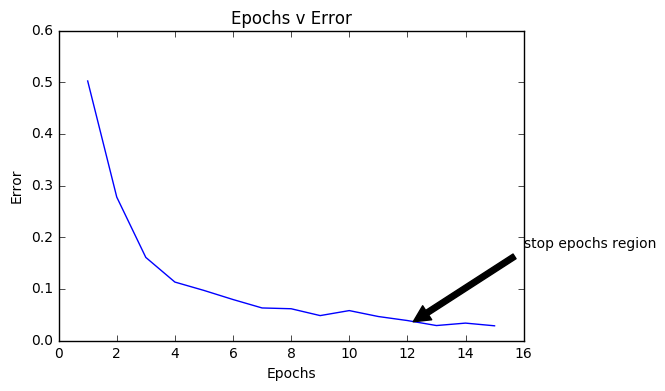

In [95]:
# print('EPOCHS: ', EPOCHS)
# print('ACCURACIES: ', len(Accuracies))

plt.title('Epochs v Error')
Error_scores = [1 - a for a in Accuracies]
plt.plot(EPOCHS_STORE, Error_scores)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.annotate('stop epochs region', xy=(12, Error_scores[12]), xytext=(16, .18),
            arrowprops=dict(facecolor='black', shrink = 0.05))
plt.show()

## Analysis:
As you can see, we really start to get marginal differences after epoch 12. The error rate also oscillates, increasing and decreasing with each epoch.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.